# Generative Adversarial Nets (GAN)

## 1. Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os

In [2]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  #Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

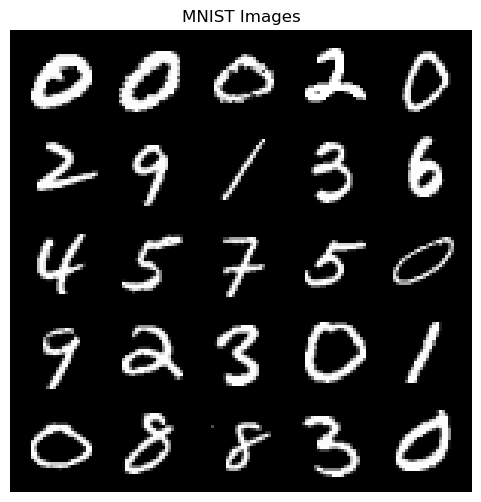

In [4]:
data_iter = iter(train_loader)
real_images, _ = next(data_iter)
grid_img = make_grid(real_images[:25], nrow=5, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.title("MNIST Images")
plt.axis("off")
plt.show()

## 2. GAN Structure

### 2.1 Generator
- Nhận đầu vào là vector nhiễu (latent vector) và thông qua các lớp Fully Connected với hàm kích hoạt ReLU,
- Cuối cùng dùng hàm Tanh để sinh ra ảnh (kích thước 28×28).

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh() #Output values in the range [-1, 1]
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

### 2.2 Discriminator
- Nhận ảnh (được flatten thành vector) và thông qua các lớp Fully Connected với hàm LeakyReLU,
- Cuối cùng sử dụng Sigmoid để cho ra xác suất ảnh là thật hay giả.

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() #Output a probability
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

## 3. Training

In [13]:
lr = 0.0002
num_epochs = 20
latent_dim = 100

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
os.makedirs("gan_images", exist_ok=True)

In [15]:
#Hyper-parameters
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [16]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size_curr = imgs.size(0)
        #Labeling
        valid = torch.ones(batch_size_curr, 1, device = device)
        fake  = torch.zeros(batch_size_curr, 1, device = device)

        real  = imgs.to(device)

        #========================#
        # GENERATOR TRAINING
        #========================#
        optimizer_G.zero_grad()
        #Create input (random noise)
        z = torch.randn(batch_size_curr, latent_dim, device = device)
        #Generator: z -> gen_img
        gen_imgs = generator(z)
        #Loss
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        #========================#
        # DISCRIMINATOR TRAINING
        #========================#
        optimizer_D.zero_grad()
        #Loss: real image
        real_loss = adversarial_loss(discriminator(real), valid)
        #Loss: fake image
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        #Discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        if i%10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} [Batch {i}/{len(train_loader)}] " +
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        
    with torch.no_grad():
        fixed_noise = torch.randn(32, latent_dim, device = device)
        fake_images = generator(fixed_noise)
        grid = make_grid(fake_images, nrow = 8, normalize = True)
        save_image(grid, f"gan_images/epoch_{epoch+1}.png")

Epoch 1/20 [Batch 0/1875] [D loss: 0.6969] [G loss: 0.6876]
Epoch 1/20 [Batch 10/1875] [D loss: 0.7502] [G loss: 0.5891]
Epoch 1/20 [Batch 20/1875] [D loss: 0.8986] [G loss: 0.4021]
Epoch 1/20 [Batch 30/1875] [D loss: 0.9103] [G loss: 0.3904]
Epoch 1/20 [Batch 40/1875] [D loss: 0.9110] [G loss: 0.3880]
Epoch 1/20 [Batch 50/1875] [D loss: 0.9130] [G loss: 0.3869]
Epoch 1/20 [Batch 60/1875] [D loss: 0.9139] [G loss: 0.3860]
Epoch 1/20 [Batch 70/1875] [D loss: 0.9158] [G loss: 0.3856]
Epoch 1/20 [Batch 80/1875] [D loss: 0.9166] [G loss: 0.3851]
Epoch 1/20 [Batch 90/1875] [D loss: 0.9154] [G loss: 0.3848]
Epoch 1/20 [Batch 100/1875] [D loss: 0.9181] [G loss: 0.3847]
Epoch 1/20 [Batch 110/1875] [D loss: 0.9167] [G loss: 0.3844]
Epoch 1/20 [Batch 120/1875] [D loss: 0.9172] [G loss: 0.3840]
Epoch 1/20 [Batch 130/1875] [D loss: 0.9177] [G loss: 0.3833]
Epoch 1/20 [Batch 140/1875] [D loss: 0.9182] [G loss: 0.3828]
Epoch 1/20 [Batch 150/1875] [D loss: 0.9192] [G loss: 0.3823]
Epoch 1/20 [Batch 1